# MATH 468 - Stochastic Calculus II - HW 6

In [1]:
'''
Packages Used
---
Data - pandas, datetime, yfinance
Numerical - numpy, scipy stats
Plotting - Matplotlib, seaborn
Custom - StoCalCodeDeck
'''
import pandas as pd
import datetime
import yfinance as yf

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import StoCalCodeDeck as stocal

## Problem 1 - Pricing and the Greeks

We consider a (european) call option on a stock with expiration in 3 months ($T = \frac{1}{4}$) and strike price $K=10$.  The annual interest rate on the market is $r=2\%$.  The current price of the stock is $S_0=10$ and we assume that the stock follows a geometric Brownian motion model with parameters $\mu=5\%$ and $\sigma=0.20$.

(a) Determine the price $F_0$ of this option at time $t=0$ (today).  
(b) Using the formulas provided in the lecturs, calculate the value of each of the greeks for this option.  Namely, calculate $\Delta$, $\Gamma$, $\nu$, $\Theta$, and $\rho$.  
(c) Find a formula for the change of the option price with respect to a change in the strike price. In other words, determine $\frac{\delta f(S_t,t)}{\delta K}$  
(d) For each of the suggested modifications below, use an approximation to determine the change in the price of the option above without actually recalculating the price. For each provide an intuitive argument to explain why the price increases or decreases.  
    (i) The rate of return $\mu$ increases to $6\%$  
    (ii) The interest rate $r$ increases to $3\%$  
    (iii) The volatility increases to $\sigma=0.3$  
    (iv) The expiration date changes to 4 months  
    (v) The strike price goes up to $\$11$  
    (vi) The current stock price rises instantaneously to $\$11$

### Solution to Part (a)

I price the option using the Black-Scholes formula and a function written for Homework 5, Problem 3

In [2]:
price = stocal.price_bsm(s0=10,k=10,r=.02,t=1/4,sigma=.2)
print('The price of the option is ${:.2f}'.format(price))

The price of the option is $0.42


### Solution to Part (b)

In [3]:
def bsm_greeks(s0, k, r, t, sigma):
    '''
    Uses the Black-Scholes formula to estimate the 5 major greeks (delta, gamma, theta, vega, rho)  
    ---  
    Parameters:  
    s0 (float) - Current stock price  
    k (float) - strike price  
    r (float) - risk-free interest rate (per annum)  
    t (float) - time to maturity, in years  
    sigma (float) - asset volatitly  
    ---  
    Returns:  
    greeks (dataframe) - calculated greeks in a dataframe indexed by name  
    '''
    import numpy as np
    from scipy.stats import norm
    greeks = pd.DataFrame(index=['delta','gamma','theta','vega','rho'],columns=['greeks'])
    d_plus = (np.log(s0/k) + (r + ((sigma ** 2) / 2)) * t) / (sigma * np.sqrt(t))
    d_less = (np.log(s0/k) + (r - ((sigma ** 2) / 2)) * t) / (sigma * np.sqrt(t))
    greeks.loc['delta'] = norm.cdf(d_plus)
    greeks.loc['gamma'] = (1 / (np.sqrt(t) * sigma * s0)) * norm.pdf(d_plus)
    greeks.loc['theta'] = (((-1)*s0) / (2 * np.sqrt(t))) * norm.pdf(d_plus) - (r * k * np.exp((-r) * t) * norm.cdf(d_less))
    greeks.loc['vega'] = s0 * np.sqrt(t) * norm.pdf(d_plus)
    greeks.loc['rho'] = np.sqrt(t) * k * np.exp((-1) * r * t) * norm.cdf(d_less)
    return greeks

In [4]:
print('Calculated Greeks')
greeks = bsm_greeks(s0=10,k=10,r=0.02,t=1/4,sigma=.2)
greeks

Calculated Greeks


,greeks
delta,0.539828
gamma,0.396953
theta,-4.069027
vega,1.984763
rho,2.487531


### Solution to Part (c)

We wish to calculate the partial derivative of the pricing function with respect to the strike price.
$$\frac{d}{dK}F = \frac{d}{dK}[S_0\Phi(d_+) - Ke^{-rT}\Phi(d_-)]$$
We rewrite this using the product rule
$$\frac{d}{dK}F = S_0\frac{d}{dK}[\Phi(d_+)] - Ke^{-rT}\frac{d}{dK}[\Phi(d_-)] - \Phi(d_-)e^{-rT}$$
We then evaluate this with the chain rule
$$\frac{d}{dK}F = S_0\phi(d_+)(\frac{d}{dK}[d_+]) - Ke^{-rT}\phi(d_-)(\frac{d}{dK}[d_-]) - \Phi(d_-)e^{-rT}$$
We now considere $\frac{d}{dK}[d_{\pm}]$.  Using properties of logs, we observe
$$\frac{d}{dK}[d_{\pm}] = \frac{d}{dK}[\frac{\mathrm{ln}(\frac{S_0}{K})+(r\pm\frac{\sigma^2}{2})T}{\sigma\sqrt{T}}]=\frac{d}{dK}[\frac{\mathrm{ln}(S_0)-\mathrm{ln}(K)+(r\pm\frac{\sigma^2}{2})T}{\sigma\sqrt{T}}]=\frac{d}{dK}[\frac{-\mathrm{ln}(K)}{\sigma\sqrt{T}}]=-\frac{1}{\sigma K \sqrt{T}}$$
Now that we see $\frac{d}{dK}[d_+]=\frac{d}{dK}[d_-]$, we can rewrite the expression
$$\frac{d}{dK}F = \frac{-1}{\sigma K \sqrt{T}}(S_0\phi(d_+) - Ke^{-rT}\phi(d_-)) - \Phi(d_-)e^{-rT}$$
Which completes the result.

We note that this value is strictly negative, which implies an increase in the strike price will decrease the price of the call option.  This makes intuitive sense as an increase in the strike price would then decrease the end value of the payoff function.

In the case of this option, we calculate this greek's value below

In [5]:
s0 = 10
k=10
r=.02
t=1/4
sigma=0.2
d_plus = (np.log(s0/k) + (r + ((sigma ** 2) / 2)) * t) / (sigma * np.sqrt(t))
d_less = (np.log(s0/k) + (r - ((sigma ** 2) / 2)) * t) / (sigma * np.sqrt(t))
kappa = (-1 / (sigma * k *np.sqrt(t))) * (s0 * stats.norm.pdf(d_plus) - k * np.exp(-r * t) * stats.norm.pdf(d_less)) - np.exp(-r*t)*stats.norm.cdf(d_less)
print('a $1 increase in strike will change the option price by ${:.2f}'.format(kappa))

a $1 increase in strike will change the option price by $-0.50


### Solution to Part (d)

In [6]:
print('Part 1: No Change')
print('Part 2: The option price changes by ${:.2f}'.format((.03-.02)*greeks.loc['rho'][0]))
print('Part 3: The option price changes by ${:.2f}'.format((0.3-0.2)*greeks.loc['vega'][0]))
print('Part 4: The option price changes by ${:.2f}'.format(((3-4)/12)*greeks.loc['theta'][0]))
print('Part 5: The option price changes by ${:.2f}'.format((11-10)*kappa))
print('Part 6: The option price changes by ${:.2f}'.format((11-10)*greeks.loc['delta'][0]))

Part 1: No Change
Part 2: The option price changes by $0.02
Part 3: The option price changes by $0.20
Part 4: The option price changes by $0.34
Part 5: The option price changes by $-0.50
Part 6: The option price changes by $0.54


## Problem 2 - Estimating parameters and option pricing

This problem is a continuation of Prob. 4 in HW5. We consider the same situation and parameters for your chosen stock.  
**Part 1 - Greeks**. Consider the call option that is ”at-the-money”. Calculate the value of Delta for this option using the formulas given in the lectures. Record the stock price one day later than your original time t = 0 and provide an estimate of the new option price on that day using your value of Delta. How does the estimate compare to the new actual market price of the call? How could you have improved your estimate?  
**Part 2 - Volatility Smile**. Record the current price $S_0$ of your chosen stock, as well as the price of several (about 10) call options with a common expiration date but different strike prices. For each option, use the current market price $C_0$, the expiration $T$ and the strike price $K$ in Black-Scholes formula and solve for the volatility $\sigma$ (see below for details). Plot the volatility as a function of the strike price. Comment on the result and what you can conclude from your graph.

*Solving for* $\sigma$.  There is no explicit way to solve for $\sigma$ in the Black-Scholes formula. You have to approach this numerically. Here are some possible approaches  
* If you are familiar with numerical equation solvers in your language of choice, you can use one of these to solve for your parameters. However, please double-check your results as pre-coded solvers do not always behave in the way that you expect and if you didn’t code it yourself, it’s hard to know exactly what it does.  
* If you are familiar with numerical methods (e.g. Newton’s method) to solve a nonlinear equation, you can use that and code it yourself.  
* Finally, a fairly direct method is to proceed empirically: you calculate the value in the Black-Scholes formula for a braid range of volatilities (e.g (0.1, 0.2, 0.3, · · · , 9.9)) and you consider the value of σ that yields the closest value to your objective.


### Part 1

In [104]:
'''ETF Data and Parameter Estimation'''
etf, etf_data = stocal.asset_data(ticker='LQD',start_date='2021-03-31',end_date='2022-03-31')
expiry, years_to_expiry = stocal.maturity(0.75, etf)
lqd_mu, lqd_sigma = stocal.estimate_params(252, etf_data)
px_last = etf_data.iloc[-1,4]
atm_k = int(px_last)
options = etf.option_chain(expiry)
calls = options.calls.set_index('contractSymbol')
rf=stocal.rates_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [105]:
'''Calculates Greeks'''
lqd_greeks = stocal.bsm_greeks(s0=px_last,k=atm_k,r=rf,t=0.75,sigma=lqd_sigma)
lqd_greeks

,greeks
delta,0.671234
gamma,0.047155
theta,-27.095929
vega,37.880967
rho,66.134999


In [106]:
options_day_prior = pd.read_csv('hw6_option_chain_day_prior.csv',
                index_col='contractSymbol')[['lastTradeDate','strike','lastPrice','bid','ask']]

atm_option_day_prior = options_day_prior[options_day_prior['strike']==atm_k]
atm_option_day_prior

,lastTradeDate,strike,lastPrice,bid,ask
contractSymbol,,,,,
LQD230120C00120000,2022-03-14 14:13:24+00:00,120.0,3.1,0.0,0.0


In [107]:
option_change = ((px_last - etf_data.iloc[-2,-2]) * lqd_greeks.loc['delta'])[0]
proj_price = atm_option_day_prior['lastPrice'][0] + option_change
print('The option price should change by ${:.2f} to ${:.2f}'.format(option_change, proj_price))
print('The actual price of the option is ${:.2f}'.format(float(calls[calls['strike']==atm_k]['lastPrice'])))

The option price should change by $0.19 to $3.29
The actual price of the option is $3.10


### Part 2

In [108]:
def bsm_implied_vol(s0,k,r,t,c0,trials=10000):
    '''
    Calculates implied volatility of an option using BSM with a brute force approach  
    ---  
    Parameters:  
    s0 (float) - current asset price  
    k (int) - strike price  
    r (float) - risk-free interest rate (per annum)  
    t (float) - time to maturity, in years  
    c0 (float) - Current call price  
    trials (int) - Trial attempts (default 10000)  
    ---  
    Returns:  
    sigma (float) - Estimated sigma  
    '''
    import pandas as pd
    import numpy as np
    from scipy.stats import norm
    diffs = []
    index = []
    for i in range(1,trials,1):
        sigma = i / trials
        index.append(sigma)
        d_plus = (np.log(s0/k) + (r + ((sigma ** 2) / 2)) * t) / (sigma * np.sqrt(t))
        d_less = (np.log(s0/k) + (r - ((sigma ** 2) / 2)) * t) / (sigma * np.sqrt(t))
        price = norm.cdf(d_plus) * s0 - norm.cdf(d_less) * k * np.exp(-r * t)
        diff = price-c0
        diffs.append(abs(diff))
    diff_df = pd.DataFrame(data=diffs,index=index)
    sigma = diff_df.idxmin()[0]
    return sigma

In [112]:
calls.head(1)

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
contractSymbol,,,,,,,,,,,,,
LQD230120C00075000,2021-11-10 11:49:48+00:00,75.0,60.1,59.9,60.85,0.0,0.0,1.0,0,0.956116,True,REGULAR,USD


In [116]:
vols = []
for call in calls.index:
    iter_k = calls.loc[call]['strike']
    iter_c0 = calls.loc[call]['lastPrice']
    sigma = bsm_implied_vol(s0=px_last,k=iter_k,r=rf,t=0.75,c0=iter_c0)
    vols.append(sigma)

[0.9634,
 0.0527,
 0.0163,
 0.2488,
 0.0001,
 0.0637,
 0.0665,
 0.071,
 0.0708,
 0.0608,
 0.0931,
 0.0841,
 0.0748,
 0.0957,
 0.0773,
 0.2294,
 0.1076,
 0.177,
 0.1894,
 0.0795,
 0.0869,
 0.1217,
 0.127,
 0.1332,
 0.1095,
 0.1515,
 0.0963,
 0.1081]

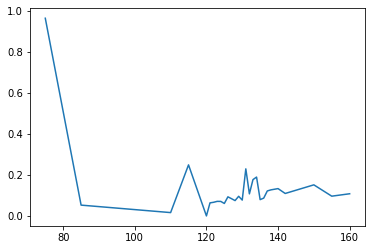

In [118]:
plt.plot(calls['strike'],vols)

## Problem 3 - Solving the Black-Scholes PDE

The purpose of this problem is to solve the Black-Scholes PDE with analytical techniques, which will lead us back to the Black-Scholes formula. The technique is very similar to the one used with the Feynman-Kac formula in Prob. 3 of HW8 in MATH 467.

Let's consider the PDE given by
$$\frac{\delta f}{\delta t} + \frac{1}{2}\sigma^2x^2\frac{\delta^2 f}{\delta x^2} + rx\frac{\delta f}{\delta x} - rf = 0$$
with terminal condition $f(T,x)=(x-K)_+$.  The solution $f(t,x)$ corresponds tot he price of a call option (given the initial condition) at time $t$ if the stock price is $x$.  
(a) The first two things that prevent us from solving this PDE directly is (i) the fact that we have a terminal condition, instead of an initial condition; and (ii) that the terms infront of the derivatives are not constant.  To address these, we use the transformation $g(t,x)=f(T-t,e^x)$, equivalent to $f(t,x)=g(T-t,log(x))$.  Under this condition, determine the PDE satisfied by $g$.  
(b) Now, the PDE has an initial condition and constant coefficient, but it still includes a first order derivative in $x$ and the function $g$ itself.  In order to simplify this, use the transformation $h(t,x)=e^{ax+bt}g(t,x)$ and determine the appropriate values of $a$ and $b$ in order for $h$ to solve the heat equation (see (c)).  
(c) We know that the solution to the heat equation $\frac{\delta u}{\delta t} - \frac{\alpha}{2}\frac{\delta^2 u}{\delta x^2} = 0$ with initial condition $u_0$ is given by
$$u(t,x) = \int_{\mathbb{R}} \frac{1}{\sqrt{2\pi\alpha t}}\mathrm{exp}\{-\frac{(x-y)^2}{2\alpha t}\}u_0(y)dy$$
Use this result to determine the function $h$.  
(d) Work the transformations backwards to determine the function $g$, and then $f$.  You should recover the Black-Scholes formula.

### Solution to Part (a)

We see $f(t,x)=g(T-t,\mathrm{log}(x))$.  Therefore  
$\frac{\delta f}{\delta t} = -\frac{\delta g}{\delta t}$  
$\frac{\delta f}{\delta t} = \frac{\delta g}{\delta x} x^{-1}$  
$\frac{\delta f}{\delta t} = \frac{\delta^2 g}{\delta x^2} x^{-2} - \frac{\delta g}{\delta x} x^{-2}$  
We can then subsitute and see
$$\begin{cases}-\frac{\delta g}{\delta t} + \frac{1}{2}\sigma^2(\frac{\delta^2 g}{\delta x^2}-\frac{\delta g}{\delta x}) + r\frac{\delta g}{\delta x} - rg = 0\\
f(T,x)=g(T-T,\mathrm{log}(x))=(x-K)_+
\end{cases}$$
and simplify this too
$$\begin{cases}-\frac{\delta g}{\delta t} + \frac{1}{2}\sigma^2\frac{\delta^2 g}{\delta x^2}+ (r-\frac{1}{2}\sigma^2)\frac{\delta g}{\delta x} - rg = 0\\
g(0,\mathrm{log}(x))=(x-K)_+
\end{cases}$$


### Solution to Part (b)

Letting $g(t,x)=\mathrm{exp}\{-ax-bt\}h(t,x)$, we see  
$\frac{\delta g}{\delta t} = h(t,x)(-b)e^{-ax-bt} + \frac{\delta h}{\delta t}e^{-ax-bt}$  
$\frac{\delta g}{\delta x} = h(t,x)(-a)e^{-ax-bt} + \frac{\delta h}{\delta x}e^{-ax-bt}$  
$\frac{\delta g^2}{\delta x^2} = h(t,x)(a^2)e^{-ax-bt} + \frac{\delta h}{\delta x}(-2a)e^{-ax-bt} + \frac{\delta^2 h}{\delta x^2}e^{-ax-bt}$  
Plugging this into the previous equation, we see
$$\begin{cases}(e^{-ax-bt})((h(t,x)b + \frac{\delta h}{\delta t}) + \frac{1}{2}\sigma^2(a^2h(t,x) - 2a\frac{\delta h}{\delta x} + \frac{\delta^2 h}{\delta x^2})+ (r-\frac{1}{2}\sigma^2)(\frac{\delta h}{\delta x}- ah(t,x)) - rh(t,x)) = 0\\
g(0,\mathrm{log}(x))=-axh(0,\mathrm{log}(x))=(x-K)_+
\end{cases}$$
By isolating the first order terms, we observe
$$b+\frac{1}{2}\sigma^2a^2-ra+\frac{1}{2}\sigma^2a-r=0$$
whicch, when rewritten becomes
$$b = (r-\frac{1}{2}\sigma^2)(a+1)$$
Letting $a=0$ since $x$ should not be present in the discount factor because it represents the stochastic process, we see $b=(r-\frac{1}{2}\sigma^2)$

### Solution to Part (c)

### Solution to Part (d)